In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

In [66]:
#!pip install opencv-contrib-python
#!pip install pytesseract
#!pip install tesseract-ocr

In [67]:
import cv2
import matplotlib.pyplot
import matplotlib.pyplot
import numpy
import pytesseract
import skimage.color
import skimage.io
import skimage.measure
import skimage.segmentation
import skimage.transform
import skimage.filters 
import matplotlib.pyplot as plt
import skimage.morphology 


In [68]:
# !pdftoppm example.pdf example -png

In [69]:
pytesseract.pytesseract.tesseract_cmd = r"tesseract"

In [70]:
mask = skimage.io.imread("./example-1-mask.png", as_gray=True)

mask = ~skimage.img_as_bool(mask)

mask = skimage.measure.label(mask)

0 36


(array([1.647096e+06, 7.414000e+04, 1.990400e+04, 2.195200e+04,
        2.609600e+04, 2.550000e+02, 4.894400e+04, 2.550000e+02,
        2.550000e+02, 2.550000e+02, 3.440000e+03, 3.139000e+03,
        6.622000e+03, 2.550000e+02, 2.880000e+02, 2.880000e+02,
        2.880000e+02, 2.550000e+02, 8.010000e+03, 7.120000e+03,
        3.649000e+03, 3.649000e+03, 4.480000e+03, 4.480000e+03,
        9.856000e+03, 2.550000e+02, 2.550000e+02, 7.429000e+04,
        2.190200e+04, 4.881600e+04, 3.060000e+02, 2.283400e+04,
        3.060000e+02, 2.190200e+04, 1.857600e+04, 6.120000e+02]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.]),
 <a list of 36 Patch objects>)

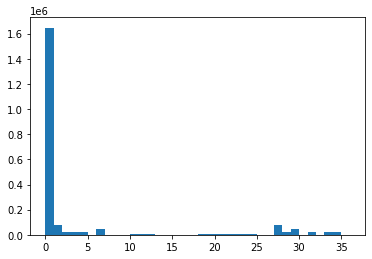

In [71]:
print(min(mask.flatten()), max(mask.flatten()))
plt.hist(mask.flatten(), bins=36)

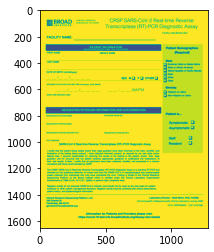

In [72]:
reference = skimage.io.imread("./example-1.png", as_gray=True)
reference = skimage.transform.resize(reference, mask.shape)
reference = skimage.img_as_ubyte(reference)
plt.imshow(reference)

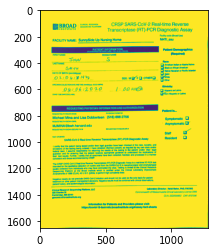

In [73]:
image = skimage.io.imread("./sample-1.png", as_gray=True)
#image = skimage.io.imread("./sample-2.png", as_gray=True)
#image = skimage.io.imread("./sample-3.png", as_gray=True)
#image = skimage.io.imread("./sample-4.png", as_gray=True)
image = skimage.transform.resize(image, mask.shape)
image = skimage.img_as_ubyte(image)
plt.imshow(image)

## Image registration

In [74]:
# TODO: replace OpenCV with scikit-image

model = cv2.AKAZE_create()

reference_keypoints, reference_descriptors = model.detectAndCompute(reference, None)
image_keypoints, image_descriptors = model.detectAndCompute(image, None)

matcher = cv2.BFMatcher()

matches = []

for m, n in matcher.knnMatch(reference_descriptors, image_descriptors, k=2):
    if m.distance < 0.75 * n.distance:
        matches.append([m])

matches_image = cv2.drawMatchesKnn(
    reference, 
    reference_keypoints, 
    image,
    image_keypoints,
    matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

reference_matched_keypoints, image_matched_keypoints = [], []

for index, match in enumerate(matches):
    reference_matched_keypoints += [reference_keypoints[match[0].queryIdx].pt]
    
    image_matched_keypoints += [image_keypoints[match[0].trainIdx].pt]

reference_matched_keypoints = numpy.float32(reference_matched_keypoints)
image_matched_keypoints = numpy.float32(image_matched_keypoints)

homography, status = cv2.findHomography(
    image_matched_keypoints, 
    reference_matched_keypoints, 
    cv2.RANSAC,
    5.0
)

registered = cv2.warpPerspective(image, homography, (mask.shape[1], mask.shape[0]))

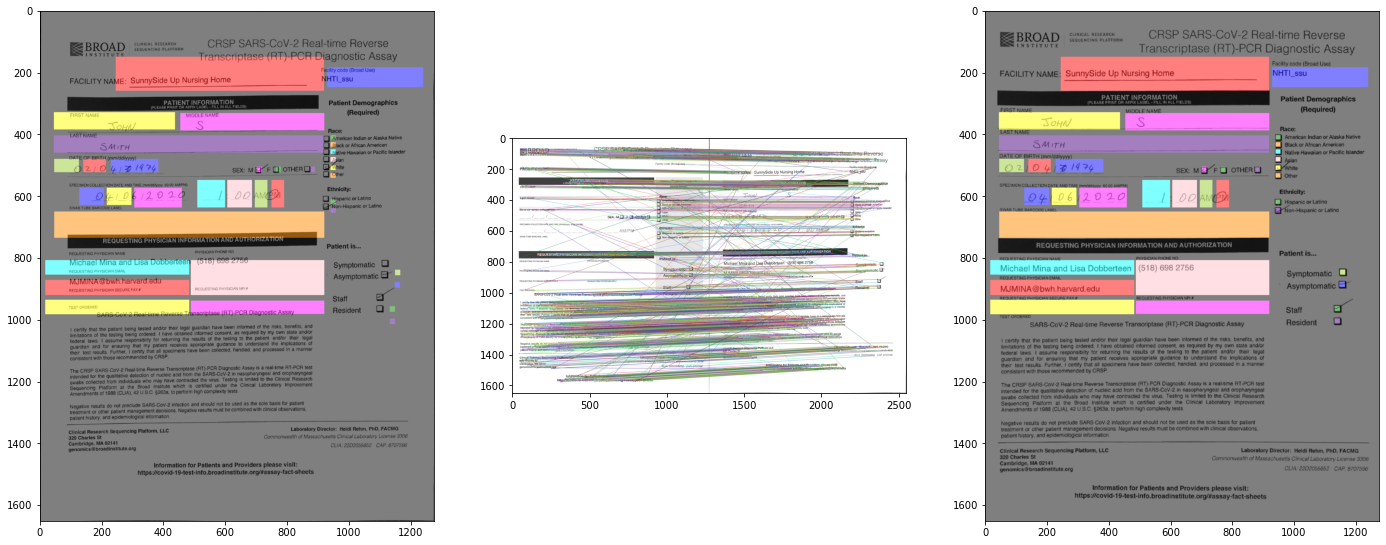

In [75]:
figure, axes = matplotlib.pyplot.subplots(ncols=3, figsize=(24, 24))

axes[0].imshow(skimage.color.label2rgb(mask, image, alpha=0.5, bg_label=0))
axes[1].imshow(matches_image)
axes[2].imshow(skimage.color.label2rgb(mask, registered, alpha=0.5, bg_label=0))

# Binarization and Masking

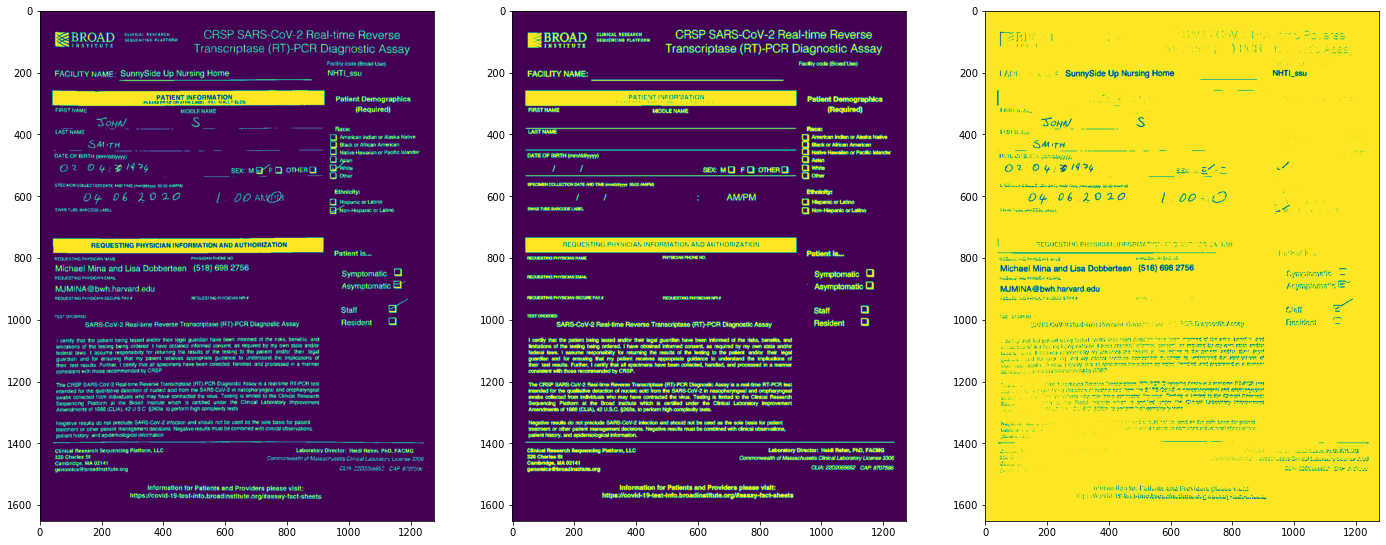

In [80]:
reference_thresh = skimage.filters.threshold_otsu(reference)
reference_binary = ~skimage.morphology.binary_erosion(~(reference < reference_thresh)) # True = foreground, False = background 

registered_thresh = skimage.filters.threshold_otsu(registered)
registered_binary = (registered < registered_thresh)  # True = foreground, False = background 

delta = skimage.img_as_ubyte(~(registered_binary * ~reference_binary))  #balck foreground, withe background

figure, axes = matplotlib.pyplot.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(registered_binary)
axes[1].imshow(reference_binary)
axes[2].imshow(delta)

## Crop Image region

In [81]:
# the key of the 36 regions specified by the mask. Order is important
keys = [
    "facility_name",
    "facility_code",
    "first_name",
    "middle_name",
    "race_american_indian_or_alaska_native",
    "last_name",
    "race_black_or_african_american",
    "race_native_hawaiian_or_pacific_islander",
    "race_asian",
    "date_of_birth_month",
    "date_of_birth_day",
    "date_of_birth_year",
    "race_white",
    "sex_male",
    "sex_female",
    "sex_other",
    "race_other",
    "speciman_collection_date_hour",
    "speciman_collection_date_minute",
    "speciman_collection_date_am",
    "speciman_collection_date_pm",
    "speciman_collection_date_month",
    "speciman_collection_date_day",
    "speciman_collection_date_year",
    "ethnicity_hispanic_or_latino",
    "ethnicity_nonhispanic_or_latino",
    "swab_tube_barcode_label",
    "requesting_physician_name",
    "physician_phone_number",
    "patient_is_symptomatic",
    "requesting_physician_email",
    "patient_is_asymptomatic",
    "requesting_physician_secure_fax",
    "requesting_physician_npi",
    "patient_is_staff",
    "patient_is_resident"
]

numeric_fields = [  
    "date_of_birth_month",
    "date_of_birth_day",
    "date_of_birth_year",
    "speciman_collection_date_month",
    "speciman_collection_date_day",
    "speciman_collection_date_year",
    "speciman_collection_date_hour",
    "speciman_collection_date_minute",
    "physician_phone_number",
    "requesting_physician_secure_fax"]

alphanumeric_fields = [
    "facility_name",
    "facility_code",
    "first_name",
    "middle_name",
    "last_name",
    "swab_tube_barcode_label",
    "requesting_physician_name",
    "requesting_physician_email",
    "requesting_physician_npi"]

sex_one_hot = ["sex_male", "sex_female", "sex_other"]
race_one_hot = [
    "race_american_indian_or_alaska_native",
    "race_black_or_african_american",
    "race_native_hawaiian_or_pacific_islander",
    "race_asian",
    "race_white",
    "race_other"]
ethnicity_one_hot = ["ethnicity_hispanic_or_latino", "ethnicity_nonhispanic_or_latino"]
symptomatic_one_hot = [ "patient_is_symptomatic", "patient_is_asymptomatic"]
patient_one_hot = ["patient_is_staff", "patient_is_resident"]
am_pm_one_hot = ["speciman_collection_date_am", "speciman_collection_date_pm"] 

one_hot_list_of_list = [
    sex_one_hot, 
    race_one_hot, 
    ethnicity_one_hot, 
    symptomatic_one_hot, 
    patient_one_hot, 
    am_pm_one_hot]

## Make association between field name and image region

In [82]:
regions_diff_dict=dict(zip(keys, skimage.measure.regionprops(mask, delta)))
#regions_diff_dict=dict(zip(keys, skimage.measure.regionprops(mask, registered)))

#Save an image to file for Stephen
#def save_cropped_imgs(keys, regions_dict, prefix):
#    for k in keys:
#        skimage.io.imsave(prefix+k+".png", regions_diff_dict[k].intensity_image)
        
#save_cropped_imgs(keys=alphanumeric_fields, regions_dict=regions_diff_dict, prefix="alphanumeric_1_")
#save_cropped_imgs(keys=numeric_fields, regions_dict=regions_diff_dict, prefix="numeric_1_")

## Read the alphanumeric fields

{'facility_name': 'SunnySide Up Nursing Home', 'facility_code': 'NHTi_ssu', 'first_name': '; Souvy', 'middle_name': 'S', 'last_name': 'SMH', 'swab_tube_barcode_label': '', 'requesting_physician_name': 'Michael Mina and Lisa Dobberteen', 'requesting_physician_email': 'MJMINA @bwh.harvard.edu', 'requesting_physician_npi': ''}


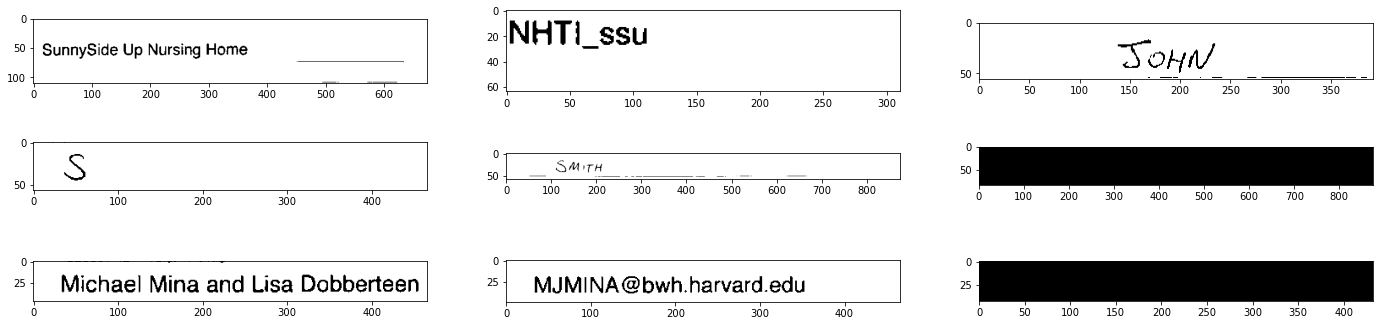

In [84]:
figure, axes = matplotlib.pyplot.subplots(nrows=3, ncols=3, figsize=(24, 6))

axes[0,0].imshow(regions_diff_dict[alphanumeric_fields[0]].intensity_image, cmap='gray')
axes[0,1].imshow(regions_diff_dict[alphanumeric_fields[1]].intensity_image, cmap='gray')
axes[0,2].imshow(regions_diff_dict[alphanumeric_fields[2]].intensity_image, cmap='gray')
axes[1,0].imshow(regions_diff_dict[alphanumeric_fields[3]].intensity_image, cmap='gray')
axes[1,1].imshow(regions_diff_dict[alphanumeric_fields[4]].intensity_image, cmap='gray')
axes[1,2].imshow(regions_diff_dict[alphanumeric_fields[5]].intensity_image, cmap='gray')
axes[2,0].imshow(regions_diff_dict[alphanumeric_fields[6]].intensity_image, cmap='gray')
axes[2,1].imshow(regions_diff_dict[alphanumeric_fields[7]].intensity_image, cmap='gray')
axes[2,2].imshow(regions_diff_dict[alphanumeric_fields[8]].intensity_image, cmap='gray')



def read_alphanumeric_fields(keys, regions_dict):
    config= '--psm 6 --oem 3'
    inferred = []
    for k in keys:
        inferred += [pytesseract.image_to_string(regions_dict[k].intensity_image, config=config)]
    return dict(zip(keys,inferred))

info_alphanumeric = read_alphanumeric_fields(keys=alphanumeric_fields, regions_dict=regions_diff_dict)
print(info_alphanumeric)




0 255
['Sou', 'Dona', 'Dona']


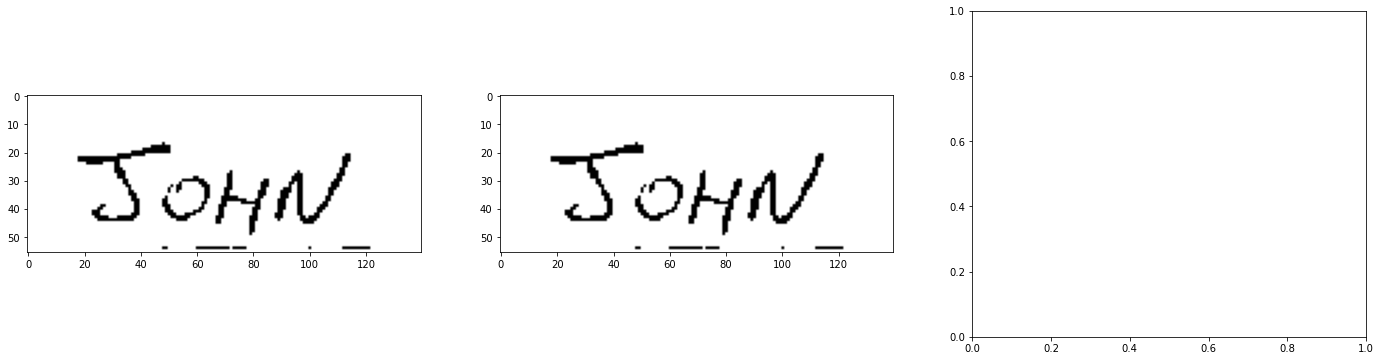

In [63]:
# Idea crop the left edge:
#plt.imshow(regions_diff_dict['first_name'].intensity_image)
#plt.hist(regions_diff_dict['first_name'].intensity_image)

a = numpy.cumsum(regions_diff_dict['first_name'].intensity_image, axis=1)
b = numpy.sum(regions_diff_dict['first_name'].intensity_image, axis=0)

cropped = regions_diff_dict['first_name'].intensity_image[:,120:260]
cropped2 = cropped*1.0/255
figure, axes = matplotlib.pyplot.subplots(ncols=3, figsize=(24, 6))
axes[0].imshow(cropped, cmap='gray')
axes[1].imshow(cropped2, cmap='gray')


print(numpy.min(cropped),numpy.max(cropped))

v=[]
v += [pytesseract.image_to_string(cropped, config= '--psm 7 --oem 3')]
v += [pytesseract.image_to_string(cropped2, config= '--psm 7 --oem 3')]
v += [pytesseract.image_to_string(cropped*1.0/255, config= '--psm 7 --oem 3')]

print(v)

## Read the numeric fields

{'date_of_birth_month': 'O2', 'date_of_birth_day': 'O4', 'date_of_birth_year': '13', 'speciman_collection_date_month': 'O', 'speciman_collection_date_day': '06', 'speciman_collection_date_year': '2020', 'speciman_collection_date_hour': '1', 'speciman_collection_date_minute': '00', 'physician_phone_number': '', 'requesting_physician_secure_fax': ''}


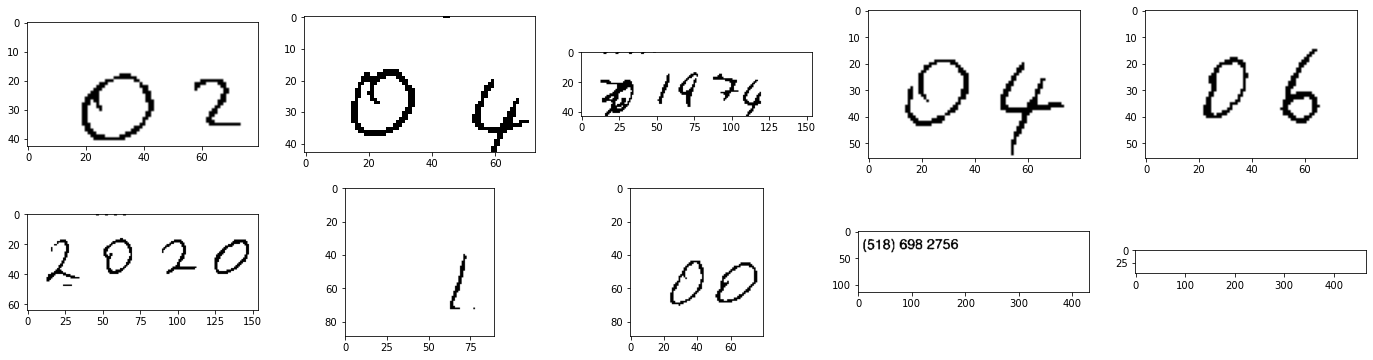

In [85]:
figure, axes = matplotlib.pyplot.subplots(nrows=2, ncols=5, figsize=(24, 6))

axes[0,0].imshow(regions_diff_dict[numeric_fields[0]].intensity_image, cmap='gray')
axes[0,1].imshow(regions_diff_dict[numeric_fields[1]].intensity_image, cmap='gray')
axes[0,2].imshow(regions_diff_dict[numeric_fields[2]].intensity_image, cmap='gray')
axes[0,3].imshow(regions_diff_dict[numeric_fields[3]].intensity_image, cmap='gray')
axes[0,4].imshow(regions_diff_dict[numeric_fields[4]].intensity_image, cmap='gray')
axes[1,0].imshow(regions_diff_dict[numeric_fields[5]].intensity_image, cmap='gray')
axes[1,1].imshow(regions_diff_dict[numeric_fields[6]].intensity_image, cmap='gray')
axes[1,2].imshow(regions_diff_dict[numeric_fields[7]].intensity_image, cmap='gray')
axes[1,3].imshow(regions_diff_dict[numeric_fields[8]].intensity_image, cmap='gray')
axes[1,4].imshow(regions_diff_dict[numeric_fields[9]].intensity_image, cmap='gray')

def read_numeric_fields(keys, regions_dict):
    #config= "--psm 7 --oem 3"
    #config= '--psm 13 --oem 3 -c tessedit_char_whitelist=" "(0123456789O)'
    config= '--psm 8 --oem 3 -c tessedit_char_whitelist=" "(0123456789O)'
    inferred = []
    for k in keys:
        inferred += [pytesseract.image_to_string(regions_dict[k].intensity_image, config=config)]
    return dict(zip(keys,inferred))

info_numeric = read_numeric_fields(numeric_fields, regions_diff_dict)
print(info_numeric)

# Read the hot encoding manually

['sex_male', 'sex_female', 'sex_other'] [16830, 6375, 0]
['race_american_indian_or_alaska_native', 'race_black_or_african_american', 'race_native_hawaiian_or_pacific_islander', 'race_asian', 'race_white', 'race_other'] [0, 0, 0, 0, 6630, 0]
['ethnicity_hispanic_or_latino', 'ethnicity_nonhispanic_or_latino'] [0, 9690]
['patient_is_symptomatic', 'patient_is_asymptomatic'] [7650, 17085]
['patient_is_staff', 'patient_is_resident'] [16320, 5865]
['speciman_collection_date_am', 'speciman_collection_date_pm'] [4845, 36720]
{'sex_male': 'Yes', 'sex_female': 'None', 'sex_other': 'None', 'race_american_indian_or_alaska_native': 'None', 'race_black_or_african_american': 'None', 'race_native_hawaiian_or_pacific_islander': 'None', 'race_asian': 'None', 'race_white': 'Yes', 'race_other': 'None', 'ethnicity_hispanic_or_latino': 'None', 'ethnicity_nonhispanic_or_latino': 'Yes', 'patient_is_symptomatic': 'None', 'patient_is_asymptomatic': 'Yes', 'patient_is_staff': 'Yes', 'patient_is_resident': 'None',

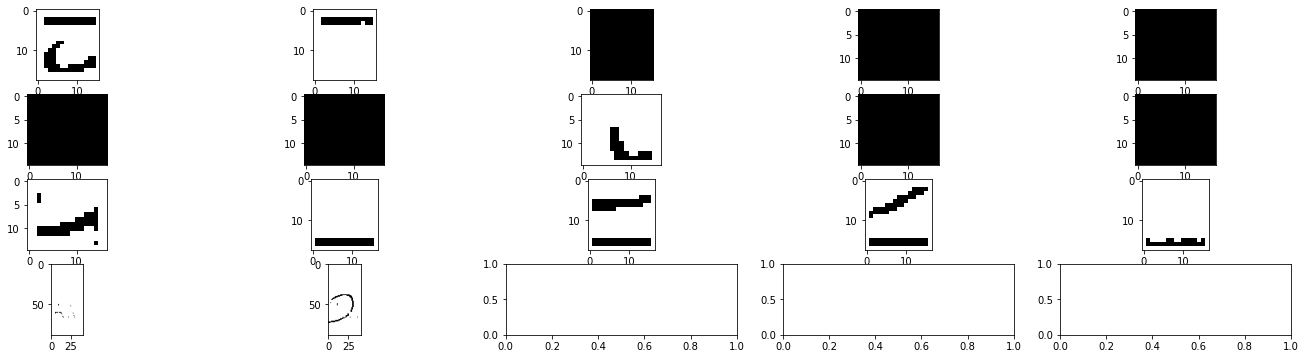

In [86]:
one_hot_flattened = [item for sublist in one_hot_list_of_list for item in sublist]

figure, axes = matplotlib.pyplot.subplots(nrows=4, ncols=5, figsize=(24, 6))

axes[0,0].imshow(regions_diff_dict[one_hot_flattened[0]].intensity_image, cmap='gray')
axes[0,1].imshow(regions_diff_dict[one_hot_flattened[1]].intensity_image, cmap='gray')
axes[0,2].imshow(regions_diff_dict[one_hot_flattened[2]].intensity_image, cmap='gray')
axes[0,3].imshow(regions_diff_dict[one_hot_flattened[3]].intensity_image, cmap='gray')
axes[0,4].imshow(regions_diff_dict[one_hot_flattened[4]].intensity_image, cmap='gray')
axes[1,0].imshow(regions_diff_dict[one_hot_flattened[5]].intensity_image, cmap='gray')
axes[1,1].imshow(regions_diff_dict[one_hot_flattened[6]].intensity_image, cmap='gray')
axes[1,2].imshow(regions_diff_dict[one_hot_flattened[7]].intensity_image, cmap='gray')
axes[1,3].imshow(regions_diff_dict[one_hot_flattened[8]].intensity_image, cmap='gray')
axes[1,4].imshow(regions_diff_dict[one_hot_flattened[9]].intensity_image, cmap='gray')
axes[2,0].imshow(regions_diff_dict[one_hot_flattened[10]].intensity_image, cmap='gray')
axes[2,1].imshow(regions_diff_dict[one_hot_flattened[11]].intensity_image, cmap='gray')
axes[2,2].imshow(regions_diff_dict[one_hot_flattened[12]].intensity_image, cmap='gray')
axes[2,3].imshow(regions_diff_dict[one_hot_flattened[13]].intensity_image, cmap='gray')
axes[2,4].imshow(regions_diff_dict[one_hot_flattened[14]].intensity_image, cmap='gray')
axes[3,0].imshow(regions_diff_dict[one_hot_flattened[15]].intensity_image, cmap='gray')
axes[3,1].imshow(regions_diff_dict[one_hot_flattened[16]].intensity_image, cmap='gray')

def resolve_one_hot(keys, regions_dict):
    """ Reverse the image so that foreground is 1 and background is zero and take maximum intensity"""
    inferred = ["None"]*len(keys)
    values_list = []
    for k in keys:
        values_list += [numpy.sum(~regions_dict[k].intensity_image)]
    values_np = numpy.asarray(values_list)
    print(keys, values_list)
    index = numpy.argmax(values_np)
    inferred[index] = "Yes" 
    return dict(zip(keys,inferred))

info_one_hot = {}
for one_hot in one_hot_list_of_list:
    tmp = resolve_one_hot(one_hot, regions_diff_dict)
    info_one_hot.update(tmp)
    
print(info_one_hot)

# Conclusion 

{'sex_male': 'Yes', 'sex_female': 'None', 'sex_other': 'None', 'race_american_indian_or_alaska_native': 'None', 'race_black_or_african_american': 'None', 'race_native_hawaiian_or_pacific_islander': 'None', 'race_asian': 'None', 'race_white': 'Yes', 'race_other': 'None', 'ethnicity_hispanic_or_latino': 'None', 'ethnicity_nonhispanic_or_latino': 'Yes', 'patient_is_symptomatic': 'None', 'patient_is_asymptomatic': 'Yes', 'patient_is_staff': 'Yes', 'patient_is_resident': 'None', 'speciman_collection_date_am': 'None', 'speciman_collection_date_pm': 'Yes'}
{'date_of_birth_month': 'O2', 'date_of_birth_day': 'O4', 'date_of_birth_year': '13', 'speciman_collection_date_month': 'O', 'speciman_collection_date_day': '06', 'speciman_collection_date_year': '2020', 'speciman_collection_date_hour': '1', 'speciman_collection_date_minute': '00', 'physician_phone_number': '', 'requesting_physician_secure_fax': ''}
{'facility_name': 'SunnySide Up Nursing Home', 'facility_code': 'NHTi_ssu', 'first_name': '; 

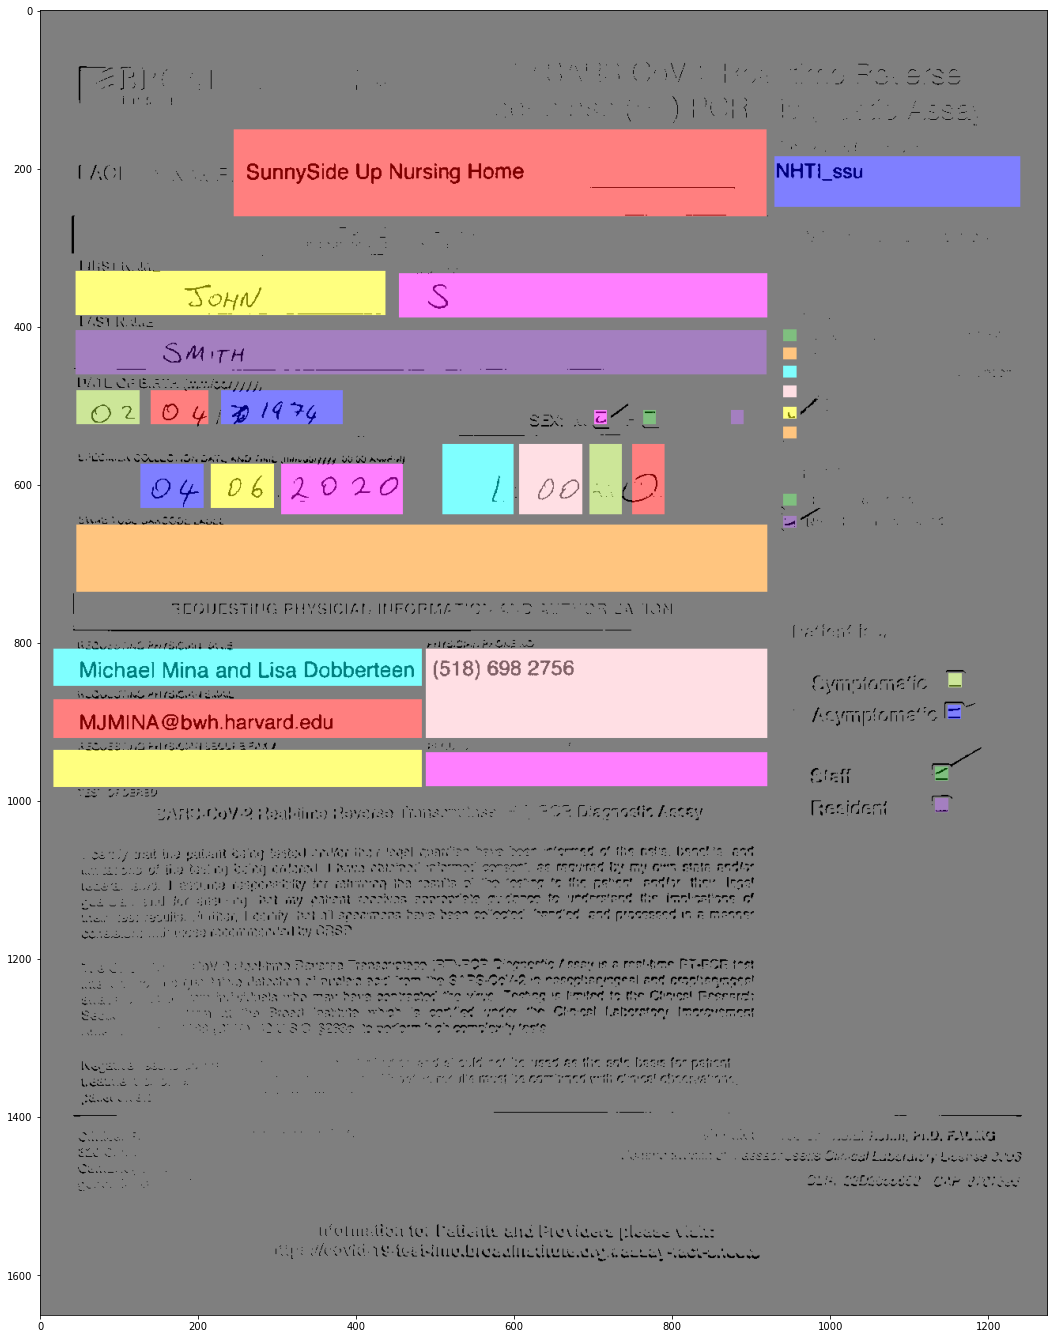

In [87]:
figure, axes = matplotlib.pyplot.subplots(ncols=1, figsize=(24, 24))
axes.imshow(skimage.color.label2rgb(mask, delta, alpha=0.5, bg_label=0))

print(info_one_hot)
print(info_numeric)
print(info_alphanumeric)